In [ ]:
# default_exp model.learner

In [ ]:
from IPython.core.debugger import set_trace
from IPython.utils import traitlets as _traitlets

/tmp/ipykernel_2733750/2943078347.py:2: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


<h1><center> Learner </center></h1>

In this module, we define the model architecture that we will use in our learner. It will be based on [`tsai`](https://github.com/timeseriesAI/tsai) models with a simple tweak: ability to handle categorical features.

The strategy to build our model is fairly simple:
+ apply a specific 'Embedding` layer to each categorical feature
+ concatenate the outcome of the embedding layers with the continuous features
+ pass the resulting tensor to a `tsai` existing model
The first 2 steps can be handled by the *head* of the network which can be seen as a layer.

Once the architecture defined, we can define our learner in the usual way and benefit from `fastai` training loop.

In [ ]:
# export
import os
import pickle
import warnings
from random import sample
from typing import List, Tuple

import numpy as np
import pandas as pd
import progressbar
from fastai.layers import trunc_normal_
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.all import *
from fastcore.basics import *
from tsai.models.RNN import *
from tsai.models.utils import *

from footSeq.datastruct.core import *

In [ ]:
data_path = "./data"
target_data = pickle.load(open(os.path.join(data_path, "targets.pkl"), "rb"))
df_main = pd.read_pickle(os.path.join(data_path, "sequences_df.pkl")).reset_index()

In [ ]:
## available playing ids
seq_ids = L(set(df_main["_id"].tolist()) & set(target_data.keys()))
labels = L(target_data.values()).unique()

In [ ]:
lbl2ids = {l: L(k for k, v in target_data.items() if v == l) for l in labels}
ids2size = df_main.groupby("_id").size().to_dict()

In order to test our different examples, let's prepare a batch of data:

In [ ]:
cat_names = [
    "type_name",
    "bodypart_name",
    "play_pattern_name",
    "is_home",
    "under_pressure",
    "counterpress",
    "is_poss_team",
    "result_name",
]
cont_names = [
    "start_x",
    "start_y",
    "end_x",
    "end_y",
    "time_seconds",
    "seconds_since_poss",
]

## splits
splits_ids = RandomSplitter()(seq_ids)

## fitst transform inspired from tabular pandas
procs = [Categorify, FillMissing, Normalize]
foot_tfm = FootSeqTransform(
    sequence_df=df_main,
    target_dict=target_data,
    ids=seq_ids,
    splits=splits_ids,
    labels=labels,
    procs=procs,
    cat_names=cat_names,
    cont_names=cont_names,
)

## to-tensor transform
to_tsr = FootSeqToTensor(cat_names, cont_names, max_len=10)

## tfmdlist
tls = TfmdLists(seq_ids, [foot_tfm, to_tsr], splits=splits_ids)

## datalodaers
train_seq_lens = L(min(ids2size[_id], 10) for _id in seq_ids[splits_ids[0]])
valid_seq_lens = L(min(ids2size[_id], 10) for _id in seq_ids[splits_ids[1]])


## pass the training dataset sequence lengths to SortedDL
srtd_dl = partial(SortedDL, res=train_seq_lens)

## Pass the validation dataset seq lengths
dl_kwargs = [{}, {"val_res": valid_seq_lens}]

## re-initialise dataloaders
srtd_dls = tls.dataloaders(
    bs=3, before_batch=pad_seq, dl_type=srtd_dl, dl_kwargs=dl_kwargs
)

##sample a batch
srtd_batch = srtd_dls.one_batch()

srtd_batch

(tensor([[[ 6,  1,  9,  1,  1,  1,  2,  5],
          [15,  1,  9,  1,  1,  1,  2,  5],
          [ 6,  1,  9,  1,  1,  1,  2,  5],
          [15,  1,  9,  1,  1,  1,  2,  5],
          [ 6,  1,  9,  1,  1,  1,  2,  5],
          [15,  1,  9,  1,  1,  1,  2,  5],
          [ 6,  1,  9,  1,  1,  1,  2,  5],
          [15,  1,  9,  1,  1,  1,  2,  5],
          [ 6,  1,  9,  1,  2,  1,  2,  5],
          [15,  1,  9,  1,  1,  1,  2,  5]],
 
         [[ 6,  1,  9,  2,  2,  1,  2,  5],
          [15,  1,  9,  2,  2,  1,  2,  5],
          [ 6,  1,  9,  2,  1,  1,  2,  5],
          [15,  1,  9,  2,  1,  1,  2,  5],
          [ 6,  1,  9,  2,  1,  1,  2,  5],
          [15,  1,  9,  2,  1,  1,  2,  5],
          [ 6,  1,  9,  2,  2,  1,  2,  5],
          [15,  1,  9,  2,  1,  1,  2,  5],
          [ 6,  1,  9,  2,  1,  1,  2,  5],
          [15,  1,  9,  2,  1,  1,  2,  1]],
 
         [[ 6,  1,  6,  1,  1,  1,  2,  5],
          [15,  1,  6,  1,  1,  1,  2,  5],
          [ 6,  1,  6,  1,

# Model

## Embedding

In [ ]:
# export


@delegates()
class Embedding(nn.Embedding):
    """
    Embedding layer compatible with full pytorch API and truncated normal initialization

    Parameters
    ----------
    ni, nf: int
        input and output size of Embedding layer. It is the same
        as `num_embeddings` and `embedding_dim` in `torch.nn.Embedding()` module
    kwargs: dict
        Any argument accepted by `torch.nn.Embedding()` module
        a part from `num_embeddings` and `embedding_dim`
    std: float
        standard deviation applied in the truncated normal

    """

    def __init__(self, ni, nf, std=0.01, **kwargs):
        kwargs["num_embeddings"], kwargs["embedding_dim"] = ni, nf
        super().__init__(**kwargs)
        trunc_normal_(self.weight.data.cuda(), std=std)


class MultiEmbedding(Module):
    """
    Muti-dimesnion Embedding layer

    Attributes
    ----------
    cat_embed: torch.nn.ModuleList
        list of Embedding modules in the order in which categorical data appear

    """

    def __init__(
        self,
        n_embeds: List[int],
        embed_dims: List[int] = None,
        embed_p: float = 0.0,
        n_cont: int = 0,
        std: float = 0.01,
        **kwargs
    ):
        """
        Initialise the various embedding sizes

        Parameters
        ----------
        n_embdes: List[int]
            length of the vocabulary of each categorical feature in the same order as passed in the tensor

        embed_dims: List[int]
            required size of each categorical feature embedding in the same order as passed in the tensor

        embed_p: float
            if non zero, applies a dropout layer to the the categorical features after embedding.

        n_cont: int, optional
            number of continuous features

        std: float
            standard deviation applied in the truncated normal
        kwargs: dict
            extra parameters passed to the embedding layer. Should be
            compatible with `torch.nn.Embedding()`

        """
        assert n_cont >= 0, "number of continuous features should be positive"
        self.n_cont = n_cont
        ## verify embedding size
        if embed_dims is None:
            embed_dims = [emb_sz_rule(s) for s in n_embeds]
        else:
            embed_dims = listify(embed_dims)
            if len(embed_dims) == 1:
                embed_dims = embed_dims * len(n_embeds)
            assert len(embed_dims) == len(n_embeds)

        self.emb_drop = nn.Dropout(embed_p)
        self.cat_embed = nn.ModuleList(
            [
                Embedding(ni=n, nf=d, std=std, **kwargs)
                for n, d in zip(n_embeds, embed_dims)
            ]
        )

    def forward(self, x_cat, x_cont=None):
        x_cat = torch.cat([e(x_cat[..., i]) for i, e in enumerate(self.cat_embed)], -1)
        x_cat = self.emb_drop(x_cat)
        if self.n_cont != 0:
            x_cat = torch.cat([x_cat, x_cont], -1)
        return x_cat

In order to test this layer, we need to find the vocabulary size of each categorical variable and pass it in `n_embeds`:

In [ ]:
n_embeds = [len(tls.to.classes[n]) for n in tls.to.cat_names]
(tls.to.cat_names, n_embeds)

((#8) ['type_name','bodypart_name','play_pattern_name','is_home','under_pressure','counterpress','is_poss_team','result_name'],
 [22, 4, 10, 3, 3, 3, 3, 7])

Now let's initialize the layer and check that it works as expected:

In [ ]:
n_cont = srtd_batch[1].shape[-1]
multi_em = MultiEmbedding(n_embeds=n_embeds, n_cont=n_cont).cuda()
tsr_em = multi_em(srtd_batch[0], srtd_batch[1])
test_eq(
    tsr_em.shape[-1],
    L(w.weight.shape[-1] for w in multi_em.cat_embed).sum() + n_cont,
)

Now let's investigate how we can use the `padding_idx` option. This can be very useful to avoid training useless weight corresponding to padding values. Let's first create a batch with some padded values:

In [ ]:
reg_dls = tls.dataloaders(bs=5, before_batch=pad_seq)
padded_batch = reg_dls.one_batch()
padded_batch[0][0]

tensor([[ 9,  1,  3,  1,  1,  1,  2,  5],
        [15,  1,  3,  1,  1,  1,  2,  5],
        [ 6,  1,  3,  1,  1,  1,  2,  5],
        [15,  1,  3,  1,  1,  1,  2,  5],
        [ 6,  1,  3,  1,  1,  1,  2,  5],
        [15,  1,  3,  1,  1,  1,  2,  5],
        [ 6,  1,  3,  1,  1,  1,  2,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0]], device='cuda:0')

In [ ]:
multi_em_pad = MultiEmbedding(n_embeds, padding_idx=0, n_cont=n_cont).cuda()
tsr_em = multi_em_pad(padded_batch[0], padded_batch[1])
tsr_em[0]

tensor([[-4.7229e-02,  3.4381e-01, -1.9350e-01, -6.3584e-02, -8.3272e-01,
         -1.1572e+00,  6.8725e-01,  3.6490e-01,  1.8027e-01, -7.8237e-01,
          2.0699e+00, -1.0519e+00, -4.3870e-02, -3.0867e-01, -5.2818e-01,
          1.1154e+00, -1.2505e+00,  1.2255e+00, -8.6861e-01,  2.2909e+00,
          2.1372e-01,  1.2483e+00,  6.5257e-01, -1.1076e+00,  3.5779e-01,
          2.3389e-03,  8.5147e-01, -1.2322e+00,  1.3202e+00, -7.1175e-01,
          2.7000e-01,  5.0699e-02, -2.5232e+00, -4.3920e-01, -1.0169e+00,
          6.9942e-02, -1.3012e+00,  1.1554e-01,  1.4720e+00, -1.4996e+00,
         -8.3240e-01],
        [ 3.8803e-01, -1.3148e+00, -1.3993e+00, -5.5086e-02,  3.6360e-01,
         -1.4334e+00,  6.0887e-01,  1.7400e+00, -1.6910e-01, -7.8237e-01,
          2.0699e+00, -1.0519e+00, -4.3870e-02, -3.0867e-01, -5.2818e-01,
          1.1154e+00, -1.2505e+00,  1.2255e+00, -8.6861e-01,  2.2909e+00,
          2.1372e-01,  1.2483e+00,  6.5257e-01, -1.1076e+00,  3.5779e-01,
          2.338

Notice how the dimension with all zeros (the default padding index) are also filled in with all zeros in the resulting tensor.

## Full Architecture

Now we are ready to plug in the embedding to any `tsai` learner. Our architecture is fairly straightforward:
+ `head` is the head of the network and runs the data through the `multiEmbedding` layer
+ `body` takes the output of `head` and run it through the desired architecture selected by the user in `ts_arch`

In [ ]:
# export


@delegates(build_ts_model)
class MixedSeqModel(Module):
    "Sequence model with an embedding head."

    def __init__(
        self,
        arch: Module,
        n_cont: int,
        c_out: int,
        embded_config: dict = None,
        **kwargs
    ):
        """
        Intialise the model architecture

        Parameters
        ----------
        arch: Module
            one of tsai Model architectures accepted by `build_ts_model()`
        c_out: int
            number of output layers
        n_cont: int
            number of continuous features
        embed_config: dict
            all parameters accepted by the `MultiEmbedding` layer
        kwargs:
            Extra parameters accepted by `build_ts_model()`

        """
        ## head of the network
        embded_config["n_cont"] = n_cont
        self.head = MultiEmbedding(**embded_config)

        ## inialise the body
        self.arch, self.c_out, self.n_cont = arch, c_out, n_cont
        self.c_in = L(w.weight.shape[-1] for w in self.head.cat_embed).sum() + n_cont
        kwargs["arch"], kwargs["c_in"], kwargs["c_out"] = (
            self.arch,
            self.c_in,
            self.c_out,
        )

        self.body = build_ts_model(**kwargs)

    def forward(self, x_cat, x_cont):
        ## run through head first
        x = self.head(x_cat, x_cont)

        return self.body(x.transpose(2, 1))

In [ ]:
from tsai.models.RNN_FCN import *

n_cont = padded_batch[1].shape[-1]

## select the architecture
ts_model = LSTM_FCN
ts_args = {"bidirectional": True, "rnn_layers": 2, "shuffle": False}

## LSTM
##ts_model = LSTM
##ts_args = {"n_layers":2, "bidirectional":True}

model = MixedSeqModel(
    arch=ts_model,
    n_cont=n_cont,
    c_out=2,
    embded_config={"n_embeds": n_embeds, "embed_p": 0.1},
    **ts_args
).cuda()
model

MixedSeqModel(
  (head): MultiEmbedding(
    (emb_drop): Dropout(p=0.1, inplace=False)
    (cat_embed): ModuleList(
      (0): Embedding(22, 9)
      (1): Embedding(4, 3)
      (2): Embedding(10, 6)
      (3): Embedding(3, 3)
      (4): Embedding(3, 3)
      (5): Embedding(3, 3)
      (6): Embedding(3, 3)
      (7): Embedding(7, 5)
    )
  )
  (body): LSTM_FCN(
    (rnn): LSTM(41, 100, num_layers=2, batch_first=True, bidirectional=True)
    (rnn_dropout): Dropout(p=0.8, inplace=False)
    (shuffle): Permute(dims=0, 2, 1)
    (convblock1): ConvBlock(
      (0): Conv1d(41, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): ConvBlock(
      (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock

In [ ]:
model(padded_batch[0], padded_batch[1])

tensor([[-0.0890,  0.1893],
        [-0.2788,  0.2713],
        [-0.1553,  0.0902],
        [-0.0499,  0.1688],
        [-0.1509,  0.1986]], device='cuda:0', grad_fn=<AddmmBackward>)

# Learner

Defining a learner at this stage is straightforward, we just need to decide on the appropriate loss function to use, pass the `dataloaders` and the metrics we want to track. Moreover, the `tsai` `ts_learner` function provides a great interface that we could extend to meet our purposes: 

## Specific class for the `Learner`
We define a specific class `MixedSeqLearner` that knows how to predict the sequence and how to show results:

In [ ]:
# export


class MixedSeqLearner(Learner):
    "`Learner` for mixed sequence data"

    def predict(self, seq_id:str):
        "Predict a sequence of play passed as a pandas DataFrame"
        dl = self.dls.test_dl(seq_id)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        b = (*tuplify(inp),*tuplify(dec_preds))
        full_dec = self.dls.decode(b)
        return full_dec,dec_preds[0],preds[0]
        

@delegates(build_ts_model)
def mixed_seq_learner(
    arch: Module,
    n_cont: int,
    c_out: int,
    embded_config: dict = None,
    # learner args
    dls=None,
    splitter=trainable_params,
    loss_func=None,
    opt_func=Adam,
    lr=defaults.lr,
    cbs=None,
    metrics=None,
    path=None,
    model_dir="models",
    wd=None,
    wd_bn_bias=False,
    train_bn=True,
    moms=(0.95, 0.85, 0.95),
    # other model args
    **kwargs
):
    """
    Interface to create a `Learner` for sequences with continuous and categorical features

    Parameters
    ----------
    arch: Module
        one of tsai Model architectures accepted by `build_ts_model()`
    c_out: int
        number of output layers
    n_cont: int
        number of continuous features
    embed_config: dict
        all parameters accepted by the `MultiEmbedding` layer

    Returns
    -------
    fastai.Learner
        Learner object with the `MixedSeqModel` model architecture

    """
    if arch is None:
        arch = LSTM

    model = MixedSeqModel(
        arch=arch, n_cont=n_cont, c_out=c_out, embded_config=embded_config, **kwargs
    )
    try:
        model.body[0], model.body[1]
        subscriptable = True
    except:
        subscriptable = False
    if subscriptable:
        splitter = ts_splitter
    if loss_func is None:
        if hasattr(dls, "loss_func"):
            loss_func = dls.loss_func
        elif hasattr(dls, "train_ds") and hasattr(dls.train_ds, "loss_func"):
            loss_func = dls.train_ds.loss_func
        elif hasattr(dls, "cat") and not dls.cat:
            loss_func = MSELossFlat()

    learn = MixedSeqLearner(
        dls=dls,
        model=model,
        loss_func=loss_func,
        opt_func=opt_func,
        lr=lr,
        cbs=cbs,
        metrics=metrics,
        path=path,
        splitter=splitter,
        model_dir=model_dir,
        wd=wd,
        wd_bn_bias=wd_bn_bias,
        train_bn=train_bn,
        moms=moms,
    )

    # keep track of args for loggers
    store_attr("arch", self=learn)

    return learn

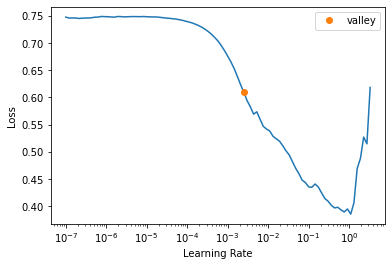

In [ ]:
from fastai.metrics import *

n_cont = padded_batch[1].shape[-1]

## prepare dataloaders
srtd_dls = tls.dataloaders(
    bs=64, before_batch=pad_seq, dl_type=srtd_dl, dl_kwargs=dl_kwargs
)

## select the architecture
ts_model = LSTM_FCN
ts_args = {"bidirectional": True, "rnn_layers": 2, "shuffle": False}
learn = mixed_seq_learner(
    arch=ts_model,
    n_cont=n_cont,
    c_out=2,
    embded_config={"n_embeds": n_embeds, "embed_p": 0.1},
    dls=srtd_dls,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    **ts_args
)
lr_ = learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.080476,0.087162,0.981570,03:10
1,0.082381,0.084545,0.981570,03:10


In [ ]:
@typedispatch
def show_results(
    x: tuple,
    y,
    samples,
    outs,
    ctxs=None,
    max_n=6,
    nrows=None,
    ncols=1,
    figsize=None,
    **kwargs
):
    n_elems = len(samples)
    if max_n > n_elems:
        max_n = n_elems
    if figsize is None:
        figsize = (10, 10 * 2.7)
    if ctxs is None:
        fig, ctxs = get_grid(
            max_n, nrows=None, ncols=ncols, figsize=figsize, return_fig=True
        )
    for i, ctx in enumerate(ctxs):
        title = f'Actual: {samples[i][1]} \n Prediction: {["goal","no_goal"][y[i].item()]}'
        samples[i].show(ctx=ctx, fig=fig, title=title)

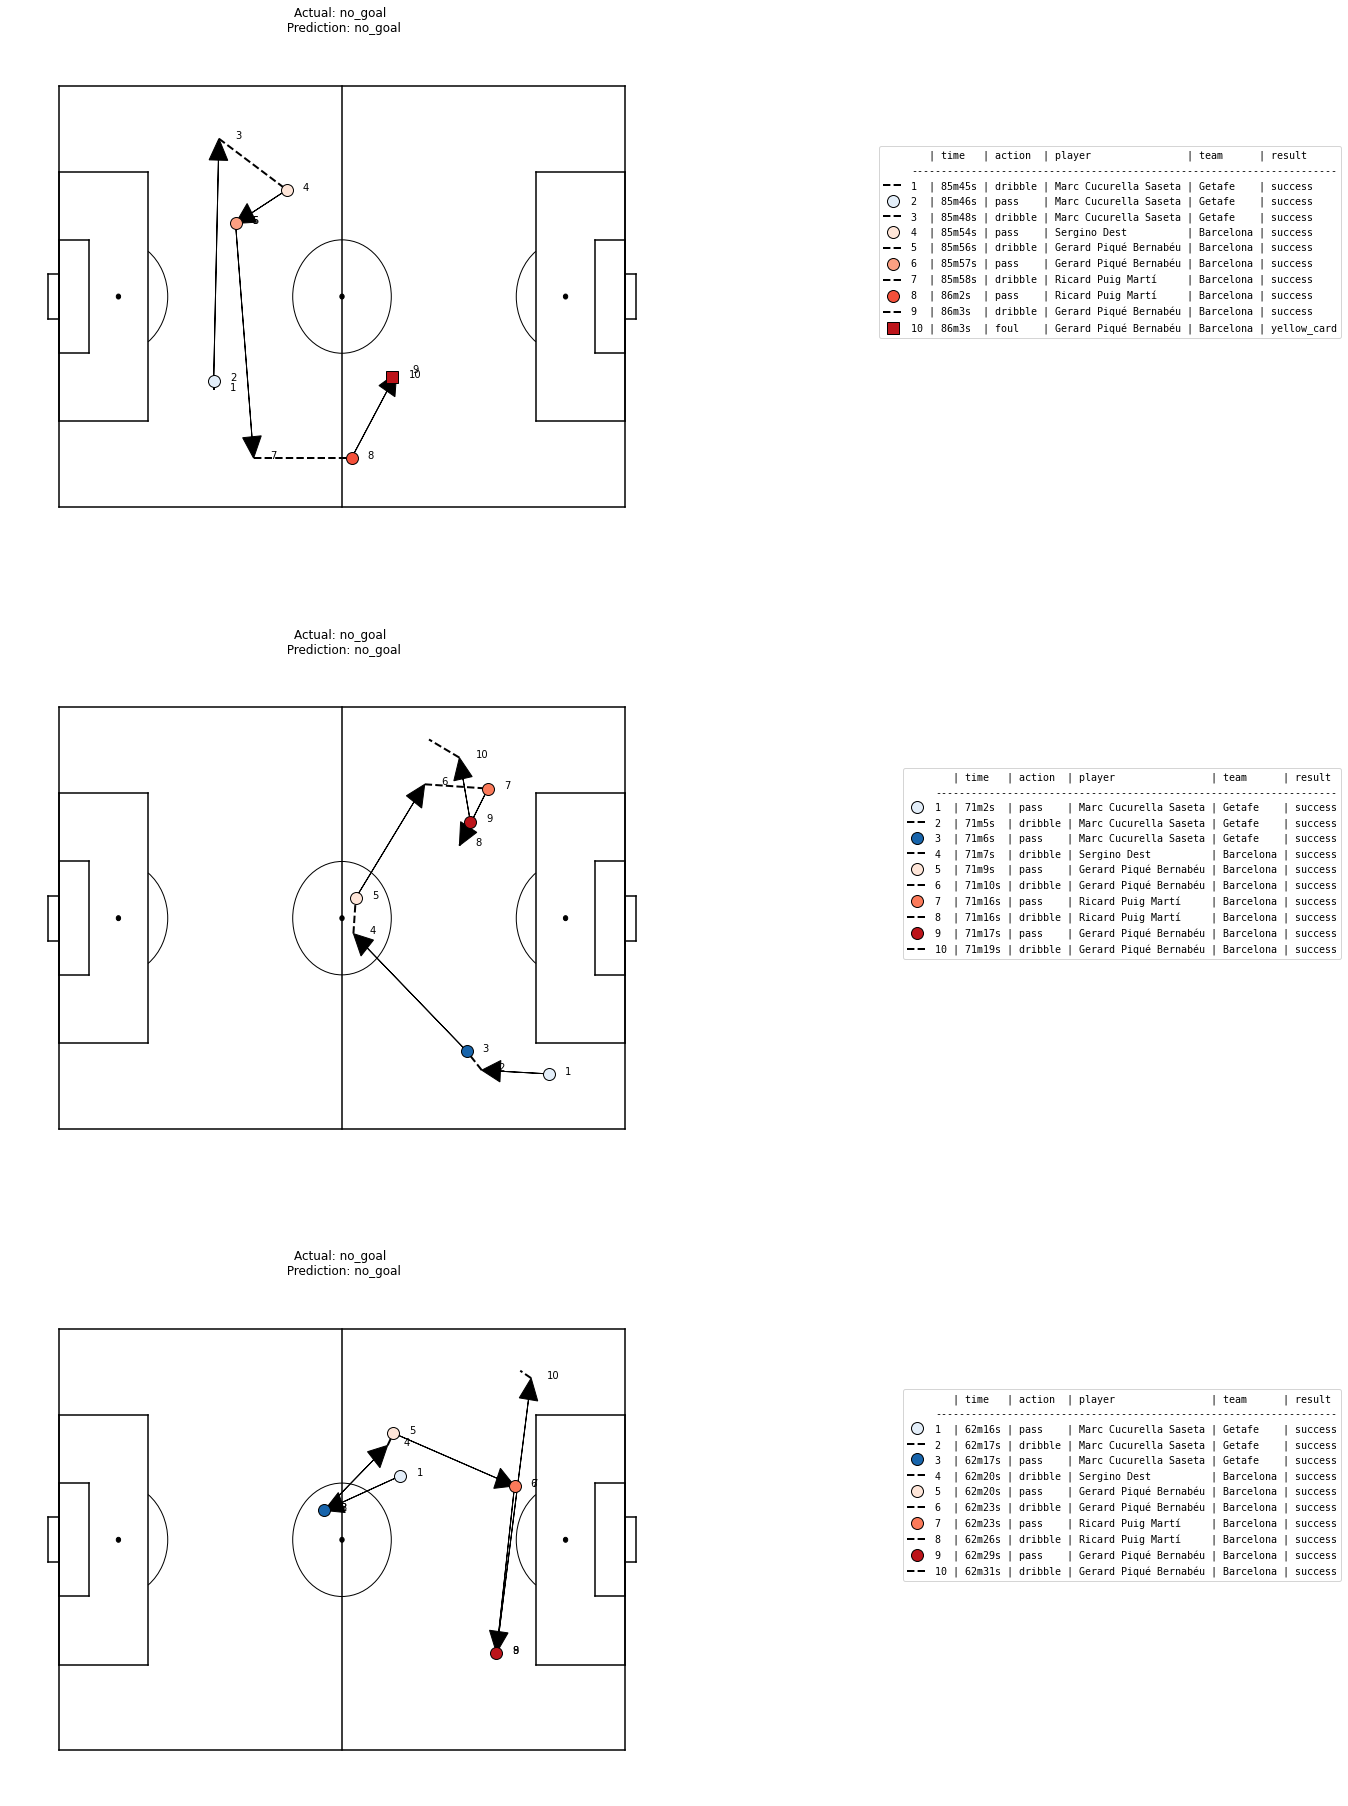

In [ ]:
base_fig_size = 12
learn.show_results(figsize = (base_fig_size, base_fig_size * 2.7), max_n=3, ncols = 1)

In [ ]:
df_main.result_name.unique()

array(['success', 'fail', 'offside', 'yellow_card', 'owngoal', 'red_card'],
      dtype=object)